In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import matplotlib as mpl
from statsmodels.stats.weightstats import DescrStatsW

# Emission Lines Observations SDSS

### SDSS galaxy sample, described by Strauss et al. (2002). <br>
### Subset of Blanton et al.’s (2003b) Sample 10, consisting of 149 660 galaxies with spectroscopic observations, 14.5 < r < 17.77 and 0.005 < z < 0.22. 

In [2]:
## data from https://wwwmpa.mpa-garching.mpg.de/SDSS/DR7/SDSS_line.html

hdul = fits.open('/Users/sachiwee/Downloads/gal_line_dr7_v5_2.fit')

In [3]:
print(hdul[1].header)

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.6a           BITPIX  =                    8 /Required value                                  NAXIS   =                    2 /Required value                                  NAXIS1  =                  952 /Number of bytes per row                         NAXIS2  =               927552 /Number of rows                                  PCOUNT  =                    0 /Normally 0 (no varying arrays)                  GCOUNT  =                    1 /Required value                                  TFIELDS =                  239 /Number of columns in table                      COMMENT                                                                         COMMENT  *** End of mandatory fields ***                                        COMMENT                                                                         COMMENT                                                                         COMMENT  *** Column names ***           

In [4]:
#emission line data
OIII=hdul[1].data['OIII_5007_flux']
NII=hdul[1].data['NII_6584_flux']
Halpha=hdul[1].data['H_ALPHA_flux']
Hbeta=hdul[1].data['H_BETA_flux']

y=OIII/Hbeta
x=NII/Halpha

/var/folders/8_/c96bc5xx7ps75wmdbb1vl_z40000gn/T/ipykernel_15662/1767017097.py:7: RuntimeWarning: divide by zero encountered in true_divide
  y=OIII/Hbeta
/var/folders/8_/c96bc5xx7ps75wmdbb1vl_z40000gn/T/ipykernel_15662/1767017097.py:7: RuntimeWarning: invalid value encountered in true_divide
  y=OIII/Hbeta
/var/folders/8_/c96bc5xx7ps75wmdbb1vl_z40000gn/T/ipykernel_15662/1767017097.py:8: RuntimeWarning: divide by zero encountered in true_divide
  x=NII/Halpha
/var/folders/8_/c96bc5xx7ps75wmdbb1vl_z40000gn/T/ipykernel_15662/1767017097.py:8: RuntimeWarning: invalid value encountered in true_divide
  x=NII/Halpha


In [5]:
print(len(x))

927552


In [6]:
hdul[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.6a           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                  952 /Number of bytes per row                         
NAXIS2  =               927552 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                  239 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** Column names **

In [7]:
#sSFR data Brinchmann et al (2004, B04)
hdulsfr = fits.open('gal_totspecsfr_dr7_v5_2.fits')

#sSFR in Gyr^-1
ssfr_obs=1e9*(10**(hdulsfr[1].data['MEDIAN']))


#gas phase metallicities

hdulz=fits.open('/Users/sachiwee/Downloads/gal_fiboh_dr7_v5_2.fits')
OH=hdulz[1].data['MEDIAN']

In [8]:
print(1e9*10**np.amax(hdulsfr[1].data['MEDIAN'][~np.isnan(hdulsfr[1].data['MEDIAN'])]))

944.0606689780828


In [9]:
hdul_sm = fits.open('/Users/sachiwee/Downloads/totlgm_dr7_v5_2.fit')

#observed median stellar mass
sm_obs=(10**(hdul_sm[1].data['MEDIAN']))

# total SFR observed data from SDSS DR7
hdul_sfr=fits.open('/Users/sachiwee/Downloads/gal_totsfr_dr7_v5_2.fits')
#SFR in M* yr^-1
sfr_obs=10.0**hdul_sfr[1].data['MEDIAN']

In [25]:
print(np.log10(np.amax(sm_obs)))

12.955361


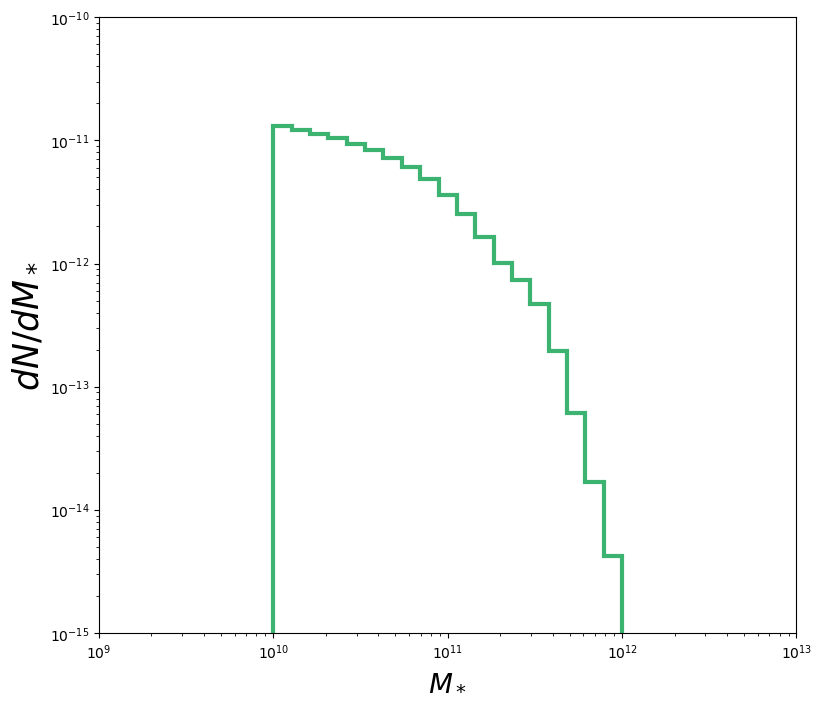

In [26]:
fig=plt.figure(figsize=(9,8))
ax=fig.add_subplot(111)
bins=np.logspace(10,12,20)
ax.hist(sm_obs,bins,histtype='step',color='mediumseagreen',linewidth=3,density=1)  
ax.set_xlabel(r'$M_*$',fontsize=20,color='k')
ax.set_ylabel(r'$dN/dM_*$',fontsize=25,color='k')
#     ax.scatter(x1,np.array(y1),c='k',s=10)
ax.set_xlim(1e9,1e13)
ax.set_ylim(1e-15,1e-10)
ax.set_yscale('log')
ax.set_xscale('log')

In [11]:
xx=np.linspace(-1.2,-0.1,1000)
xb=np.linspace(-2,0.4,1000)
x3=np.linspace(-0.3,1.5,1000)

#Kewley+1
sb=(0.61/(xb-0.47))+ 1.19

#Kauffmann+3
sf=(0.61/(xx-0.05))+ 1.3
li=1.89*x3+0.76

In [20]:
def galacticus(name):
    '''Get emission line data from galacticus. '''
    file=h5py.File(name,'r')
    
    #merger tree weight
    w=file['Outputs']['Output1']['nodeData']['mergerTreeWeight'][:]

    Lalpha=file['Outputs']['Output1']['nodeData']['luminosityEmissionLineDisk:balmerAlpha6565'][:]+file['Outputs']['Output1']['nodeData']['luminosityEmissionLineSpheroid:balmerAlpha6565'][:]
#     LNII=file['Outputs']['Output1']['nodeData']['luminosityEmissionLineDisk:nitrogenII6550'][:]+file['Outputs']['Output1']['nodeData']['luminosityEmissionLineSpheroid:nitrogenII6550'][:]
    LNII=file['Outputs']['Output1']['nodeData']['luminosityEmissionLineDisk:nitrogenII6585'][:]+file['Outputs']['Output1']['nodeData']['luminosityEmissionLineSpheroid:nitrogenII6585'][:]
    LOII=file['Outputs']['Output1']['nodeData']['luminosityEmissionLineDisk:oxygenII3727'][:]+file['Outputs']['Output1']['nodeData']['luminosityEmissionLineSpheroid:oxygenII3727'][:]
    LOII=LOII+file['Outputs']['Output1']['nodeData']['luminosityEmissionLineDisk:oxygenII3730'][:]+file['Outputs']['Output1']['nodeData']['luminosityEmissionLineSpheroid:oxygenII3730'][:]
    #Halpha Luminosity in ergs/s
#     Lalpha=file['Outputs']['Output1']['nodeData']['luminosityEmissionLineDisk:balmerAlpha6565'][:]+file['Outputs']['Output1']['nodeData']['luminosityEmissionLineSpheroid:balmerAlpha6565'][:]
    Lbeta=file['Outputs']['Output1']['nodeData']['luminosityEmissionLineDisk:balmerBeta4863'][:]+file['Outputs']['Output1']['nodeData']['luminosityEmissionLineSpheroid:balmerBeta4863'][:]

#     LNII=file['Outputs']['Output1']['nodeData']['luminosityEmissionLine:nitrogenII6585'][:]

    LOIII=file['Outputs']['Output1']['nodeData']['luminosityEmissionLineDisk:oxygenIII5008'][:]+file['Outputs']['Output1']['nodeData']['luminosityEmissionLineSpheroid:oxygenIII5008'][:]
    SFR=file['Outputs']['Output1']['nodeData']['spheroidStarFormationRate'][:]+file['Outputs']['Output1']['nodeData']['diskStarFormationRate'][:]
    stellar_mass=file['Outputs']['Output1']['nodeData']['diskMassStellar'][:]+file['Outputs']['Output1']['nodeData']['spheroidMassStellar'][:]
    
    y=np.log10(LOIII/Lbeta)
    x=np.log10(LNII/Lalpha)
    
    sSFR= SFR/stellar_mass
    # mass of metals in gas
    Metals_gas=file['Outputs']['Output1']['nodeData']['spheroidAbundancesGasMetals'][:]+file['Outputs']['Output1']['nodeData']['diskAbundancesGasMetals'][:]

    #mass of gas
    H_gas=file['Outputs']['Output1']['nodeData']['diskMassGas'][:]+file['Outputs']['Output1']['nodeData']['spheroidMassGas'][:]
    solar_z=0.0189
    print(LOIII)
    print(Lbeta)
    Zp=(Metals_gas/H_gas)/solar_z

    # O/H metallicity
    Z=np.log10(Zp)+8.69
    return x,y,Z,stellar_mass,sSFR,w
# test='/Users/sachiwee/Research/Carnegie/emissionLines_1000_test2.hdf5'
# test='/Users/sachiwee/Research/Carnegie/emissionLines_1000_test2_recent30_SFH.hdf5'
# test='/Users/sachiwee/Research/Carnegie/emissionLines_1000_test2_recent30_SFH_mres2-5e9_SFRsph_e0-05.hdf5'
test='/Volumes/LaCie/Research/Carnegie/emissionLines_4000_test4.hdf5'
# test='/Users/sachiwee/Research/Carnegie/emissionLines_1000_test2_recent30_SFH_mres2-5e9_SFRsph_cV50.hdf5'
x_gal,y_gal,z_gal,stellar_mass,ssfr_gal,w_gal=galacticus(test)

/var/folders/8_/c96bc5xx7ps75wmdbb1vl_z40000gn/T/ipykernel_2772/1268293162.py:23: RuntimeWarning: invalid value encountered in true_divide
  y=np.log10(LOIII/Lbeta)
/var/folders/8_/c96bc5xx7ps75wmdbb1vl_z40000gn/T/ipykernel_2772/1268293162.py:24: RuntimeWarning: invalid value encountered in true_divide
  x=np.log10(LNII/Lalpha)
/var/folders/8_/c96bc5xx7ps75wmdbb1vl_z40000gn/T/ipykernel_2772/1268293162.py:26: RuntimeWarning: invalid value encountered in true_divide
  sSFR= SFR/stellar_mass


[9.99978857e+35 1.49830859e+36 8.77051542e+35 ... 3.00344058e+37
            nan 3.76063457e+37]
[3.39737729e+35 1.54868614e+35 1.33887987e+35 ... 1.32782121e+37
 1.15983607e+37 1.37582044e+37]


/var/folders/8_/c96bc5xx7ps75wmdbb1vl_z40000gn/T/ipykernel_2772/1268293162.py:35: RuntimeWarning: invalid value encountered in true_divide
  Zp=(Metals_gas/H_gas)/solar_z
/var/folders/8_/c96bc5xx7ps75wmdbb1vl_z40000gn/T/ipykernel_2772/1268293162.py:38: RuntimeWarning: invalid value encountered in log10
  Z=np.log10(Zp)+8.69


In [14]:
file=h5py.File(test,'r')

#Lalpha, Lbeta, L_OIII are the same, L_NII different
Lbeta=file['Outputs']['Output1']['nodeData']['luminosityEmissionLineDisk:balmerBeta4863'][:]
# +file['Outputs']['Output1']['nodeData']['luminosityEmissionLineSpheroid:balmerBeta4863'][:]

# LNII=file['Outputs']['Output1']['nodeData']['luminosityEmissionLineDisk:nitrogenII6585'][:]+file['Outputs']['Output1']['nodeData']['luminosityEmissionLineSpheroid:nitrogenII6585'][:]

Lalpha=file['Outputs']['Output1']['nodeData']['luminosityEmissionLineDisk:balmerAlpha6565'][:]
# +file['Outputs']['Output1']['nodeData']['luminosityEmissionLineSpheroid:balmerAlpha6565'][:]
# LOIII=file['Outputs']['Output1']['nodeData']['luminosityEmissionLineDisk:oxygenIII5008'][:]+file['Outputs']['Output1']['nodeData']['luminosityEmissionLineSpheroid:oxygenIII5008'][:]
#     SFR=file['Outputs']['Output1']['nodeData']['spheroidStarFormationRate'][:]+file['Outputs']['Output1']['nodeData']['diskStarFormationRate'][:]

In [15]:
print(Lbeta)
print(Lalpha)

[3.39737729e+35 1.54868614e+35 1.33887987e+35 ... 1.32782121e+37
 1.15983607e+37 1.37582044e+37]
[9.68259463e+35 4.44324490e+35 3.81585676e+35 ... 3.78468858e+37
 3.30580895e+37 3.92198721e+37]


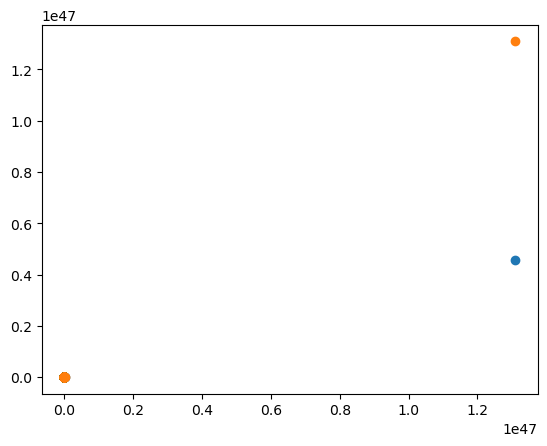

In [16]:
plt.scatter(Lalpha,Lbeta)
plt.scatter(Lalpha,Lalpha)

/var/folders/8_/c96bc5xx7ps75wmdbb1vl_z40000gn/T/ipykernel_2772/1684120360.py:10: RuntimeWarning: divide by zero encountered in log10
  sco=ax.scatter(np.log10(x),np.log10(y),c=np.log10(ssfr_obs),cmap='coolwarm' ,vmin=-2,vmax=3,s=4,alpha=.5,label='SDSS (DR7)')
/var/folders/8_/c96bc5xx7ps75wmdbb1vl_z40000gn/T/ipykernel_2772/1684120360.py:10: RuntimeWarning: invalid value encountered in log10
  sco=ax.scatter(np.log10(x),np.log10(y),c=np.log10(ssfr_obs),cmap='coolwarm' ,vmin=-2,vmax=3,s=4,alpha=.5,label='SDSS (DR7)')


[917.4907  808.56213 825.596   801.98676 899.8423  836.7955  944.06067
 838.70874 808.8303  944.06067 891.25055 814.9937  860.99365 944.06067
 835.5093  824.5714  908.51697 870.96375 930.572   813.17834 904.1692
 944.06067 808.7477  830.1272  917.27515 863.4759  853.59155 917.27515
 944.06067]
[-0.6957882  -0.6503002  -0.68564063 -0.6706025  -0.6924223  -0.6310461
 -0.85506225 -0.558282   -0.6923177  -0.6192115  -0.9353179  -0.75024843
 -0.95659477 -1.7156078  -0.7841188  -0.49218056 -0.68592733 -0.7389937
 -0.7807149  -0.6897269  -0.839145   -0.87201136 -0.95955336 -0.81959534
 -0.6877412  -0.417519   -0.92038774 -1.0321988  -0.7474285 ]
[ 0.0942475   0.14512011 -0.15603766 -0.04403018  0.15112507  0.05135064
  0.19244787  0.042683    0.00613794  0.30237764  0.49456146  0.20537142
  0.41473576  0.74628425  0.12948792 -0.41372007 -0.03975194  0.34807235
  0.15577246  0.02073611  0.3243002   0.14206985  0.38343886  0.323773
  0.46673214 -0.3503605   0.45977005  0.46864977 -0.14607471]


/var/folders/8_/c96bc5xx7ps75wmdbb1vl_z40000gn/T/ipykernel_2772/1684120360.py:65: RuntimeWarning: divide by zero encountered in log10
  print(np.log10(x)[ssfr_obs>800])
/var/folders/8_/c96bc5xx7ps75wmdbb1vl_z40000gn/T/ipykernel_2772/1684120360.py:65: RuntimeWarning: invalid value encountered in log10
  print(np.log10(x)[ssfr_obs>800])
/var/folders/8_/c96bc5xx7ps75wmdbb1vl_z40000gn/T/ipykernel_2772/1684120360.py:66: RuntimeWarning: divide by zero encountered in log10
  print(np.log10(y)[ssfr_obs>800])
/var/folders/8_/c96bc5xx7ps75wmdbb1vl_z40000gn/T/ipykernel_2772/1684120360.py:66: RuntimeWarning: invalid value encountered in log10
  print(np.log10(y)[ssfr_obs>800])


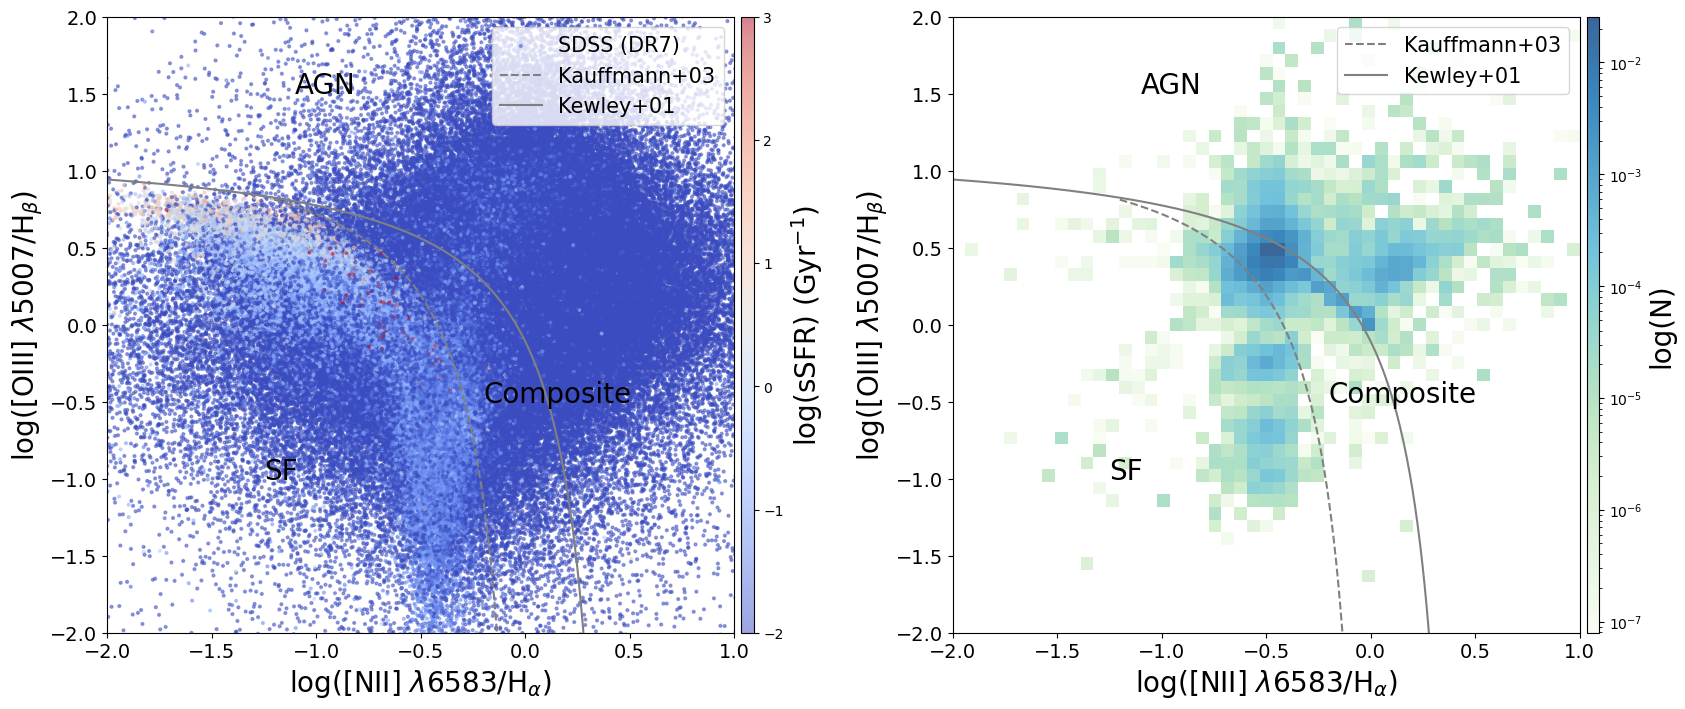

In [36]:
fig=plt.figure(figsize=(20,8))
ax=fig.add_subplot(121)

maskzo=(OH<=9.5)&(OH>=7.67)
mask=(z_gal<=9.5)&(z_gal>=7.67)

sfrobs=ssfr_obs>100

# masksfr=ssfr_gal>100
sco=ax.scatter(np.log10(x),np.log10(y),c=np.log10(ssfr_obs),cmap='coolwarm' ,vmin=-2,vmax=3,s=4,alpha=.5,label='SDSS (DR7)')
# sco=ax.scatter(np.log10(x[sfrobs]),np.log10(y[sfrobs]),c=np.log10(ssfr_obs[sfrobs]),cmap='coolwarm' ,vmin=-2,vmax=3,s=10,alpha=.5,label='SDSS (DR7, $sSFR>100\,Gyr^{-1}$)')
# sco=ax.scatter(np.log10(x[maskzo]),np.log10(y[maskzo]),c=np.log10(ssfr_obs[maskzo]),cmap='coolwarm' ,vmin=-2,vmax=3,s=4,alpha=.5,label='SDSS (DR7, 7.67 ≲ 12 + log O/H ≲ 9.5)')
# sco=ax.scatter(np.log10(x[ssfr_obs>.05]),np.log10(y[ssfr_obs>.05]),c=OH[ssfr_obs>.05],cmap='viridis' ,vmin=8,vmax=9.4,s=.1,alpha=.5,label='SDSS (DR7, $sSFR>0.05\,Gyr^{-1}$)')
cb=fig.colorbar(sco, ax=ax, aspect=50,fraction=.1,pad=0.01)

cb.set_label(r'log(sSFR) ($\mathrm{Gyr}^{-1}$)',size=20)

# cb.set_label(r'12 + log(O/H) ($\mathrm{Z}_{\odot}$)',size=20)
ax.text(-1.25,-1,'SF',size=20,color='k')
ax.text(-1.1,1.5,'AGN',size=20,color='k')
ax.text(-0.2,-0.5,'Composite',size=20,color='k')

ax.plot(xx,sf,c='grey',linestyle='--',label='Kauffmann+03')
ax.plot(xb,sb,c='grey',linestyle='-',label='Kewley+01')
ax.set_xlim(-2,1)
ax.set_ylim(-2,2)
ax.set_xlabel(r'log([NII] $\lambda6583$/$\mathrm{H}_{\alpha})$',size=20)
ax.set_ylabel(r'log([OIII] $\lambda$5007/$\mathrm{H}_{\beta})$',size=20)


# ax.scatter(x[masksfr],y[masksfr], marker='h',s=80,c='royalblue',label=r'Galacticus ($\mathrm{sSFR}>0.1\,\mathrm{Gyr^{-1}}$)',alpha=.5,edgecolor='k')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=15,loc='upper right')

ax1=fig.add_subplot(122)
# sco1=ax1.scatter(x_gal,y_gal,c=np.log10(ssfr_gal),cmap='coolwarm',vmin=-2,vmax=3,s=10,alpha=0.5,label='Galacticus ')
sco1=ax1.hist2d(x_gal,y_gal,bins=(np.linspace(-2,1,50),np.linspace(-2,2,50)),weights=w_gal,norm=mpl.colors.LogNorm(),cmap='GnBu',alpha=.8,label='Galacticus')
# sco1=ax1.scatter(x_gal[masksfr],y_gal[masksfr],c=np.log10(ssfr_gal[masksfr]),cmap='coolwarm',vmin=-2,vmax=3,s=10,alpha=0.5,label='Galacticus, $sSFR>100\,Gyr^{-1}$')
# sco1=ax1.scatter(x_gal[mask],y_gal[mask],c=np.log10(ssfr_gal[mask]),cmap='coolwarm',vmin=-2,vmax=3,s=4,alpha=0.5,label='Galacticus (7.67 ≲ 12 + log O/H ≲ 9.5)')
# sco1=ax1.scatter(x_gal,y_gal,c=z_gal,cmap='coolwarm',vmin=8,vmax=9.4,s=.1,alpha=0.5,label='Galacticus ($sSFR>0.05\,Gyr^{-1}$)')
# sco=ax.scatter(np.log10(x),np.log10(y),c=np.log10(ssfr_obs),cmap='coolwarm' ,vmin=-2,vmax=3,s=.1,alpha=.5,label='SDSS (DR7)')
cb1=fig.colorbar(sco1[3], ax=ax1, aspect=50,fraction=.1,pad=0.01)

cb1.set_label(r'log(N)',size=20)
# cb1.set_label(r'12 + log(O/H) ($\mathrm{Z}_{\odot}$)',size=20)
# cb.set_label(r'Z ($\mathrm{Z}_{\odot}$)',size=20)
ax1.text(-1.25,-1,'SF',size=20,color='k')
ax1.text(-1.1,1.5,'AGN',size=20,color='k')
ax1.text(-0.2,-0.5,'Composite',size=20,color='k')

ax1.plot(xx,sf,c='grey',linestyle='--',label='Kauffmann+03')
ax1.plot(xb,sb,c='grey',linestyle='-',label='Kewley+01')
ax1.set_xlim(-2,1)
ax1.set_ylim(-2,2)
ax1.set_xlabel(r'log([NII] $\lambda6583$/$\mathrm{H}_{\alpha})$',size=20)
ax1.set_ylabel(r'log([OIII] $\lambda$5007/$\mathrm{H}_{\beta})$',size=20)


# ax.scatter(x[masksfr],y[masksfr], marker='h',s=80,c='royalblue',label=r'Galacticus ($\mathrm{sSFR}>0.1\,\mathrm{Gyr^{-1}}$)',alpha=.5,edgecolor='k')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.legend(fontsize=15,loc='upper right')
fig.savefig('/Volumes/LaCie/Research/Carnegie/figures/BPT_obs_SDSSDR7_Galacticus_4000test4.png')
# fig.savefig('../figures/BPT_obs_SDSSDR7_Galacticus_recent30_sSFR_maskz_cV50_SFRsph0-05.png')
print(ssfr_obs[ssfr_obs>800])
print(np.log10(x)[ssfr_obs>800])
print(np.log10(y)[ssfr_obs>800])

# Star Formation Histories
### SFHs 

In [ ]:
# test='/Users/sachiwee/Research/Carnegie/emissionLines_1000_test2_recent30_SFH.hdf5'
# test='/Users/sachiwee/Research/Carnegie/emissionLines_1000_test2_recent30_SFH.hdf5'
# test='/Users/sachiwee/Research/Carnegie/emissionLines_1000_test2_recent30_SFH_mres2-5e9_SFRsph_e0-05.hdf5'
# test='/Users/sachiwee/Research/Carnegie/emissionLines_1000_test2_recent30_SFH_mres2-5e9_SFRsph_e0-05_cV50.hdf5'
# test='/Users/sachiwee/Research/Carnegie/emissionLines_1000_test2_recent30_SFH_mres2-5e9_SFRsph_cV50.hdf5'
file=h5py.File(test,'r')
mass=file['Outputs']['Output1']['nodeData']['basicMass'][:]
sfh_disk = file['Outputs']['Output1']['nodeData']['diskStarFormationHistoryMass'][:]
sfhTotal_disk = list(map(lambda x: sum(x), sfh_disk))

sfh_sph = file['Outputs']['Output1']['nodeData']['spheroidStarFormationHistoryMass'][:]
sfhTotal_sph = list(map(lambda x: sum(x), sfh_sph))

mass_sph= file['Outputs']['Output1']['nodeData']['spheroidMassStellar'][:]
mass_disk= file['Outputs']['Output1']['nodeData']['diskMassStellar'][:]

SFR=file['Outputs']['Output1']['nodeData']['spheroidStarFormationRate'][:]+file['Outputs']['Output1']['nodeData']['diskStarFormationRate'][:]
stellar_mass=mass_sph+mass_disk

w=file['Outputs']['Output1']['nodeData']['mergerTreeWeight'][:]
# file['Outputs']['Output1']['nodeData']['time'][:]

In [ ]:
total_sfh=sfhTotal_disk+sfhTotal_sph


# time=np.logspace(0,13.74,390)

In [ ]:
print(SFR)

In [ ]:
# print(len(sfhTotal_sph[mask][masksfr]))
time=file['Outputs']['Output1']['nodeData']['diskStarFormationHistoryMass'].attrs['time']
# plt.hi

In [ ]:
list(file['Outputs']['Output1']['nodeData'].keys())

In [ ]:
fig1=plt.figure(figsize=(20,8))
ax1=fig1.add_subplot(111)
cnt=0

cmap='viridis_r'
norm = mpl.colors.Normalize(vmin=5, vmax=11)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
colors = [ plt.cm.get_cmap(cmap)(norm(x)) for x in  np.log10(stellar_mass) ]



for i in range(len(x_gal)):
#     if(cnt==9):
        if(z_gal[i]<=9.5)&(z_gal[i]>=7.67):
#             if(ssfr_gal[i]==0.05):
            if(Lalpha[i]>1e43):
                ax1.plot(time*1000,(total_sfh[i]),c=colors[i])
                print(ssfr_gal[i])
            cnt=cnt+1

ax1.set_ylim(1,1e10)
ax1.set_xlim(13.8e3-40,13.8e3)
# ax1.set_xlim(0,13.8e3)
ax1.set_ylabel(r'log($\mathrm{M}_*(t)$) $[\mathrm{M}_{\odot}]$',size=20)
ax1.set_xlabel(r'time [Myrs]',size=20)
ax1.xaxis.set_tick_params(labelsize=12,labelcolor='k')
ax1.yaxis.set_tick_params(labelsize=12,labelcolor='k')

ax1.set_yscale('log')
cb2 = fig1.colorbar(sm,pad=0.01)
cb2.set_label('$\mathrm{M}_*\,[\mathrm{M}_{\odot}]$', rotation=90, fontsize=25)
# fig1.savefig('../figures/SFH_zcut_case1_13Gyr.png')

In [ ]:
deltat=np.zeros(len(time))
for i in range(len(time)):
    if(i==0):
        deltat[i]=1e3*time[i]
    else:
        
        deltat[i]=1e3*(time[i]-time[i-1])

In [ ]:
fig11=plt.figure(figsize=(20,8))
ax11=fig11.add_subplot(111)
cnt=0

cmap='viridis_r'
norm = mpl.colors.Normalize(vmin=5, vmax=11)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
colors = [ plt.cm.get_cmap(cmap)(norm(x)) for x in  np.log10(stellar_mass) ]



for i in range(len(x_gal)):
        if(z_gal[i]<=9.5)&(z_gal[i]>=7.67):
#             if(ssfr_gal[i]==0.05):
            if(Lalpha[i]>1e43):
                ax11.plot(time*1000,total_sfh[i]/(1e6*deltat[i]),c=colors[i])

            cnt=cnt+1

# ax11.set_ylim(1,1e10)
# ax1.set_xlim(13.8e3-30,13.8e3)
ax11.set_xlim(0,13.8e3)
ax11.set_ylabel(r'SFR $[\mathrm{M}_{\odot}/yr]$',size=20)
ax11.set_xlabel(r'time [Myrs]',size=20)
ax11.xaxis.set_tick_params(labelsize=12,labelcolor='k')
ax11.yaxis.set_tick_params(labelsize=12,labelcolor='k')
ax11.set_ylim(1e-8,4)
ax11.set_xticks(np.arange(0,13.8e3,500))
ax11.set_yscale('log')
cb21 = fig11.colorbar(sm,pad=0.01)
cb21.set_label('$\mathrm{M}_*\,[\mathrm{M}_{\odot}]$', rotation=90, fontsize=25)
# fig11.savefig('../figures/SFR_zcut_case2_13Gyr_cV50.png')

In [ ]:
plt.hist(np.log10(x[maskzo]),np.linspace(-2,1,50),histtype='step',color='b',alpha=.5)
plt.hist(x_gal[mask],np.linspace(-2,1,50),color='r',alpha=.5)
# plt.hist(np.log10(x_gal[mask]),color='r',alpha=.5)


In [ ]:
print(ssfr_obs[maskzo]*sm_obs[maskzo])

In [ ]:
fig2=plt.figure(figsize=(10,10))
ax2=fig2.add_subplot(111)
ax2.scatter(1,1,c='k',label='SDSS (DR7)',s=5)
# ax2.hist2d(sm_obs,sfr_obs,bins=(np.logspace(6,13,100),np.logspace(-4,2,100)),norm=mpl.colors.LogNorm(),cmap='Greys',alpha=.5,label='SDSS (DR7)')
ax2.hist2d(sm_obs[maskzo],sfr_obs[maskzo],bins=(np.logspace(6,13,100),np.logspace(-4,2,100)),norm=mpl.colors.LogNorm(),cmap='Greys',alpha=.5,label='SDSS (DR7, 7.67 ≲ 12 + log O/H ≲ 9.5)')
# ax2.hexbin(sm_obs,sfr_obs,gridsize=(100,100),bins='log',xscale='log',yscale='log',cmap='viridis',mincnt=0,label='SDSS (DR7)')
ax2.scatter(stellar_mass,SFR*1e-9,s=10,c='mediumseagreen',label='Galacticus')
ax2.scatter(stellar_mass[mask],SFR[mask]*1e-9,s=10,c='mediumseagreen',label='Galacticus (7.67 ≲ 12 + log O/H ≲ 9.5)')

ax2.set_ylabel(r'log(SFR) $[\mathrm{M}_{\odot}/\mathrm{yr}^{-1}]$',size=20)
ax2.set_xlabel(r'log($\mathrm{M}_*)\,[\mathrm{M}_{\odot}]$',size=20)
ax2.set_xlim(1e5,1e13)
ax2.set_ylim(1e-4,1e2)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend(fontsize=15)
fig2.savefig('../figures/SFR_Mstar_.png')

In [ ]:
fig3=plt.figure(figsize=(12,10))
ax3=fig3.add_subplot(111)
# ax4=fig3.add_subplot(122)
# ax3.scatter(1,1,c='k',label='SDSS (DR7)',s=5)
sc3=ax3.scatter(sm_obs,sfr_obs,c=np.log10(ssfr_obs),s=10,cmap='coolwarm' ,vmin=-2,vmax=3,label='SDSS (DR7)')

bins = np.logspace(6, 11,100)
delta = bins[1]-bins[0]

#returns output array of indices
idx  = np.digitize(sm_obs,bins)
idx_gal  = np.digitize(stellar_mass,bins)

median_obs = [np.median(sfr_obs[idx==k]) for k in range(100)]
p10_obs = [np.percentile(sfr_obs[idx==k],10) for k in range(100)]
p25_obs = [np.percentile(sfr_obs[idx==k],25) for k in range(100)]
p75_obs = [np.percentile(sfr_obs[idx==k],75) for k in range(100)]
p90_obs = [np.percentile(sfr_obs[idx==k],90) for k in range(100)]


# p10_gal=wq.quantile(probs=.1, return_pandas=False)
# median_gal = [np.median(SFR[idx_gal==k])*1e-9 for k in range(100)]
med_gal=np.zeros(100)
p10_gal=np.zeros(100)
p25_gal=np.zeros(100)
p75_gal=np.zeros(100)
p90_gal=np.zeros(100)

for k in range(100):   
    #apply weights to SFR array when index of bin == bin
    wq = DescrStatsW(data=SFR[idx_gal==k], weights=w[idx_gal==k])
    
    med_gal[k]=wq.quantile(probs=.5, return_pandas=False)*1e-9
#     print(med_gal[k])
    p10_gal[k]=wq.quantile(probs=.1, return_pandas=False)*1e-9
    p25_gal[k]=wq.quantile(probs=.25, return_pandas=False)*1e-9
    p75_gal[k]=wq.quantile(probs=.75, return_pandas=False)*1e-9
    p90_gal[k]=wq.quantile(probs=.90, return_pandas=False)*1e-9
        
# p10_gal = [wq.quantile(probs=.1, return_pandas=False)*1e-9 for k in range(100)]
# p25_gal = [np.percentile(SFR[idx_gal==k],25)*1e-9 for k in range(100)]
# p75_gal = [np.percentile(SFR[idx_gal==k],75)*1e-9 for k in range(100)]
# print(running_median)
# plt.scatter(X,Y,color='k',alpha=.2,s=2)

# ax3.plot(bins-delta/2,p10_obs,c='g',ls='-',lw=4,alpha=.8,label='p 10')
# ax3.plot(bins-delta/2,p25_obs,c='gold',ls='-',lw=4,alpha=.8,label='p 25')
ax3.plot(bins-delta/2,median_obs,c='r',ls='-',lw=4,alpha=.8,label='Median (SDSS)')
# ax3.plot(bins-delta/2,p75_obs,c='coral',ls='-',lw=4,alpha=.8,label='p 75')
# ax3.plot(bins-delta/2,p90_obs,c='k',ls='-',lw=4,alpha=.8,label='p 90')
# print(p25_gal)
# ax4.scatter(stellar_mass,SFR*1e-9,s=10,c=np.log10(ssfr_gal),cmap='coolwarm' ,vmin=-2,vmax=3,label='Galacticus ($v_{charac}=50\,km/s,\,SFR e_{sph}=0.05$)')

# ax4.plot(bins-delta/2,p10_gal,c='g',ls='-',lw=4,alpha=.8,label='p 10')
# ax4.plot(bins-delta/2,p25_gal,c='gold',ls='-',lw=4,alpha=.8,label='p 25')

ax3.plot(bins-delta/2,med_gal,c='lime',ls='-',lw=4,alpha=.8,label='Median (Galacticus)')

# ax4.plot(bins-delta/2,p75_gal,c='coral',ls='-',lw=4,alpha=.8,label='p 75')
# ax4.plot(bins-delta/2,p90_gal,'k-',lw=4,alpha=.8,label='p 90')


ax3.set_ylabel(r'log(SFR) $[\mathrm{M}_{\odot}/\mathrm{yr}^{-1}]$',size=20)
ax3.set_xlabel(r'log($\mathrm{M}_*)\,[\mathrm{M}_{\odot}]$',size=20)
ax3.set_xlim(1e5,1e11)
ax3.set_ylim(1e-4,1e3)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.legend(fontsize=15)

# ax4.set_ylabel(r'log(SFR) $[\mathrm{M}_{\odot}/\mathrm{yr}^{-1}]$',size=20)
# ax4.set_xlabel(r'log($\mathrm{M}_*)\,[\mathrm{M}_{\odot}]$',size=20)
# ax4.set_xlim(1e5,1e11)
# ax4.set_ylim(1e-4,1e3)
# ax4.set_xscale('log')
# ax4.set_yscale('log')
# ax4.legend(fontsize=15)

cb3=fig3.colorbar(sc3, ax=[ax3], aspect=50,fraction=.1,pad=0.01)

cb3.set_label(r'log(sSFR) ($\mathrm{Gyr}^{-1}$)',size=20)
fig3.savefig('../figures/SFR_Mstar_all_test_recent30_SFRsph0-05_cV50_compare.png')

In [ ]:
print(np.logspace(0,13.74,5000))

In [ ]:
print(np.amax(ssfr_obs[~np.isnan(ssfr_obs)]))

In [ ]:
plt.hist(ssfr_obs,np.logspace(-3,3,1000))
plt.ylim(0,100)